Felipe Bartelt de Assis Pessoa - 2016026841

# Treinamento e visualização
Tomou-se 400 amostras de treino, tendo metade dessas $\mathcal{N}(2,2,0.4)$ e as demais $\mathcal{N}(4,4,0.4)$, ou seja, 200 amostras bidimensionais com média $2$ e desvio padrão $0.4$ e 200 amostras com média $4$ e desvio padrão $0.4$, assim como é apresentado no código R das intruções deste exercício.

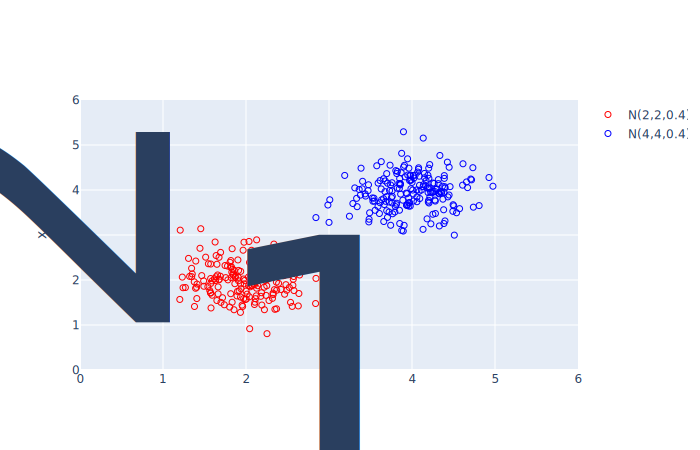

In [1]:
import numpy as np
import plotly.graph_objects as go

# Select normal distributed samples with different means
N = 200
xc1 = np.random.default_rng().normal(2,0.4,(N,2))
xc2 = np.random.default_rng().normal(4,0.4,(N,2))

# Join samples into input matrix (with x0)
x1x2 = np.append(xc1,xc2,0)
X_sample = np.append(np.ones((np.shape(x1x2)[0],1)), x1x2, 1)
x1, x2 = np.split(x1x2, 2, 1)

fig = go.Figure(go.Scatter(x=xc1[:,0],y=xc1[:,1], mode= 'markers', name ='N(2,2,0.4)', marker = dict(color = 'red', symbol = 'circle-open')))
fig.add_trace(go.Scatter(x=xc2[:,0],y=xc2[:,1], mode= 'markers', name ='N(4,4,0.4)', marker = dict(color = 'blue', symbol = 'circle-open')))
fig.update_layout(xaxis_title = 'x<sub>1</sub>',yaxis_title = 'x<sub>2</sub>', xaxis_range = [0,6], yaxis_range = [0,6])

fig.show(renderer = 'svg')

Com a visualização das amostras geradas, percebe-se que é possível realizar uma separação linear dos conjuntos. Tomou-se, assim, a função de ativação sigmoidal logística $h(u) = \frac{1}{1+e^{-u}}$, assumindo $y=0$ para a amostra vermelha e $y=1$ para a amostra azul.

Para garantir convexidade, tomou-se como função de custo não o erro quadrático, mas $J = -\frac{1}{N}\left(y^T\ln{\left(h(xw)\right)}+(1-y^T)\ln{\left(1-h(xw)\right)}\right)$, onde $x\in\mathbb{M}^{N\times p}(\mathbb{R}), w\in\mathbb{M}^{p\times 1}(\mathbb{R})$ e $y\in\mathbb{M}^{N\times 1}(\mathbb{R})$, sendo $x$ já aumentado de uma coluna unitária e $N$ o número de amostras de treino.

A derivada parcial da função de custo escolhida é dada por: $\frac{\partial J}{\partial w} = \frac{1}{N}\left(x^T\left(h\left(xw\right)-y\right)\right)$. Preferiu-se minimizar a função de custo pelo método simplex, dado pela função `scipy.optimize.fmin`, devido à melhor performance e não haver necessidade em escolha de passo, algo que pode tornar o algoritmo lento, se o passo é pequeno, ou divergente, caso o passo seja muito grande.

Inicializou-se o vetor de pesos $w$ inicial com uma distribuição uniforme no intervalor $[-\epsilon,\epsilon]$, onde $\epsilon = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$, sendo $L_{in}$ o número de neurônios da camada anterior e $L_{out}$ o número de neurônios da camada posterior.

Treinou-se a rede utilizando todas as amostras e obteve-se o vetor de pesos otimizado:

In [2]:
from scipy.optimize import fmin

# Force y vector based on colors plotted
y_sample = np.append(np.zeros((N,1)),np.ones((N,1)),0)

# Randomly initialize weigth vector
L_in = np.shape(X_sample)[1]
L_out = np.shape(y_sample)[1]
epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
w = np.random.default_rng().uniform(-epsilon,epsilon,(3,1))

def activation_function(z):
    # Logistic function
    return 1/(1+np.exp(-z))

def cost_function(weigth_vector, input_samples, output_samples, reg_par = 0):
    m = np.shape(input_samples)[0]
    u = activation_function(input_samples @ weigth_vector)
    J = -1/m*(output_samples.T @ np.log(u) + (1 - output_samples).T 
              @ (np.log(1 - u))) + sum(reg_par/(2*m)*(weigth_vector[1::]**2))
    return J.flatten()

def grad_cost(weigth_vector, input_samples, output_samples, reg_par = 0):
    m = np.shape(input_samples)[0]
    u = activation_function(input_samples @ weigth_vector)
    grad = 1/m*(input_samples.T @ (u - output_samples)) 
    return np.ndarray.flatten(grad)

w = fmin(cost_function, w, args=(X_sample, y_sample))
print('w = ', w.flatten()) # [w0 w1 w2...]

Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 175
         Function evaluations: 314
w =  [-59.11271914   9.7892136   10.74371774]


Com o vetor de pesos obtidos, pôde-se plotar a linha separadora do conjunto por $x_2 = -\frac{w_1}{w_2}x_1 -\frac{w_0}{w_2}$. O gráfico pode então ser visualizado por:

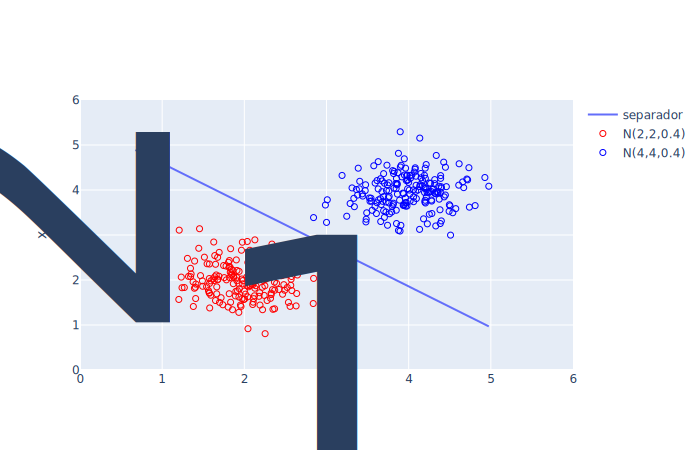

In [3]:
# Get line equation
a = -w[1]/w[2]
b = -w[0]/w[2]
line = a*x1+b

fig2 = go.Figure(go.Scatter(x = x1.flatten(),y = line.flatten(), name = 'separador'))
fig2.add_trace(go.Scatter(x=xc1[:,0],y=xc1[:,1], mode= 'markers', name ='N(2,2,0.4)', marker = dict(color = 'red', symbol = 'circle-open')))
fig2.add_trace(go.Scatter(x=xc2[:,0],y=xc2[:,1], mode= 'markers', name ='N(4,4,0.4)', marker = dict(color = 'blue', symbol = 'circle-open')))
fig2.update_layout(xaxis_title = 'x<sub>1</sub>',yaxis_title = 'x<sub>2</sub>', xaxis_range = [0,6], yaxis_range = [0,6])

fig2.show(renderer ='svg')


É possível plotar a superfície de resposta, tomando-se os pesos obtidos e utilizando todo o plano $x_1\times x_2$ como conjunto de amostras. Essa implementação, assim como a superfície de resposta, pode ser vista a seguir:

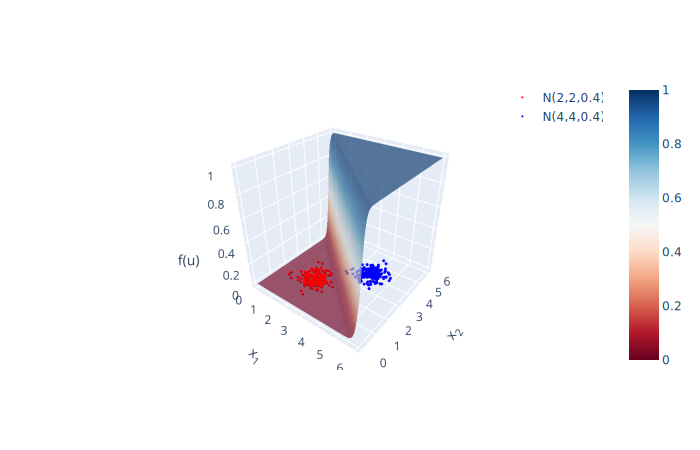

In [9]:
# Approximate sigmoid activation for all x1,x2 in grid
xgrid = np.linspace(0,6,2*N)
t1,t2 = np.meshgrid(xgrid,xgrid)
aux = np.append(np.reshape(t1.ravel(), (-1,1)),np.reshape(t2.ravel(), (-1,1)),1)
aux2 = np.append(np.ones((np.shape(aux)[0],1)),aux,1)
sig_surf = np.reshape(activation_function(aux2 @ w), np.shape(t1))


fig3=go.Figure(go.Surface(x=xgrid,y=xgrid,z=sig_surf, colorscale='RdBu', opacity=0.7))
fig3.add_trace((go.Scatter3d(x=xc1[:,0],y=xc1[:,1],z=np.zeros(np.shape(xc1[:,0])), mode= 'markers', name ='N(2,2,0.4)', marker = dict(color = 'red', symbol = 'circle', size=1.7))))
fig3.add_trace(go.Scatter3d(x=xc2[:,0],y=xc2[:,1], z=np.zeros(np.shape(xc1[:,0])),mode= 'markers', name ='N(4,4,0.4)', marker = dict(color = 'blue', symbol = 'circle', size =1.7)))
fig3.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.8),scene= dict(xaxis = dict(title='x<sub>1</sub>', tickangle=0),yaxis=dict(title='x<sub>2</sub>', tickangle=0),zaxis=dict(title='f(u)',tickangle=0), camera = dict(eye = dict(x = 1.3, y = -1.7, z = 1.3))), width =500, height=500, margin=dict(l = 80, r = 80, t = 80, b = 80))

fig3.show(renderer ='svg')

# Treinamento e Teste

Para essa rotina, tomou-se os pontos gerados no exercício anterior, uma vez que o número de amostras era o mesmo e seria uma forma de visualizar o treinamento.

Apesar de se utilizar os pontos gerados anteriormente, treinou-se novamente a rede neural, uma vez que acima essa fora treinada com todos as amostras. Assim, separou-se aleatoriamente $70\%$ das amostras para treino e as $30\%$ demais para teste. Os pesos foram inicializados da mesma forma que no primeiro exercício. Tanto a função de custo quanto o algoritmo de minimização não foram alterados.

Para a classificação das entradas, criou-se uma função, cujo parâmetro de entrada é a resposta à função de ativação, que classifica como $1$ caso o valor da sigmoide seja maior ou igual a $0.5$ e $0$ caso contrário.

Criou-se uma função para a obtenção da matriz de confusão, que, por vantagens computacionais, tem um formato diferente do habitual, sendo: 
$$
\begin{aligned}
&\quad predicted\\ 
&\quad\begin{matrix}0 & \quad 1\end{matrix} \\ 
actual\begin{matrix}0\\1\end{matrix}
&\begin{vmatrix}
TN & FP\\
FN & TP
\end{vmatrix}
\end{aligned}
$$

Também foi implementada a função para cálculo de acurácia, que pode ser definida tanto pela matriz de confusão por $acc = \frac{TP+TN}{TP+TN+FP+FN}$ ou por uma operação matricial $acc = 1- \frac{1}{N}(y-\widehat{y})^T(y-\widehat{y})$, onde $N$ é o número de amostras.

Ao final, obteve-se precisão $1$ tanto para as amostras de treino quanto para as amostras de teste. Esse valor é mostrado, assim como as matrizes de confusão.

In [10]:
N = np.shape(X_sample)[0]
N_train = round(0.7*N)
N_test = N-N_train

# Get training and test samples randomly
rand_idx = np.arange(N)
np.random.default_rng().shuffle(rand_idx)
X_train = X_sample[rand_idx[0:N_train],:]
X_test = X_sample[rand_idx[N_train::],:]
y_train = y_sample[rand_idx[0:N_train],:].astype(int)
y_test = y_sample[rand_idx[N_train::],:].astype(int)

# Randomly initialize weigth vector
L_in = np.shape(X_train)[1]
L_out = np.shape(y_train)[1]
epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
w = np.random.default_rng().uniform(-epsilon,epsilon,(3,1))

def predict_label(y):
    # Return the label corresponding to sigmoid value
    return 1*(y >= 0.5)

def eval_accuracy(y_hat, y):
    N = np.shape(y)[0]
    return (1-((y-y_hat).T @ (y-y_hat))/N).ravel()

def get_confusion_matrix(y_hat, y):
    # 0   1 --> pred
    # TN FP  0 actual
    # FN TP  1
    n_labels = len(np.unique(y))
    confusion_mat = np.zeros((n_labels,n_labels))

    for true,pred in zip(y,y_hat):
        confusion_mat[true, pred] +=1

    return confusion_mat

# Training and testing neural network
w = np.reshape(fmin(cost_function, w, args=(X_sample, y_sample)), (-1,1))
y_hat_train = predict_label(activation_function(X_train @ w))
y_hat_test = predict_label(activation_function(X_test @ w))

# Compute confusion matrix and accuracy
mat_train = get_confusion_matrix(y_hat_train,y_train.flatten())
mat_test = get_confusion_matrix(y_hat_test,y_test.flatten())

accuracy_train = eval_accuracy(np.reshape(y_hat_train,(-1,1)),y_train)
accuracy_test = eval_accuracy(np.reshape(y_hat_test,(-1,1)),y_test)

print('\nAcuracia nas amostras de treino: ', float(accuracy_train))
print('Acuracia nas amostras de teste: ', float(accuracy_test))
print('\nMatriz de confusao para treino')
print(mat_train)
print('Matriz de confusao para teste')
print(mat_test)

Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 205
         Function evaluations: 358

Acuracia nas amostras de treino:  1.0
Acuracia nas amostras de teste:  1.0

Matriz de confusao para treino
[[147.   0.]
 [  0. 133.]]
Matriz de confusao para teste
[[53.  0.]
 [ 0. 67.]]


Para melhor visualização da matriz de confusão, a mesma é plotada na forma de um mapa de calor. A implementação é a que segue e abaixo a imagem final:

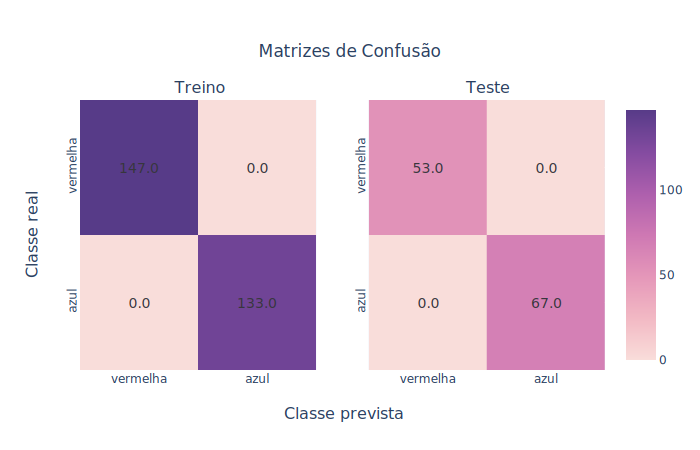

In [11]:
from plotly.subplots import make_subplots

def plot_confusion_matrix(cm_list, labels, title):
# cm_list : confusion matrices [cm_train, cm_test]
# labels : name of the data list(str)
# title : title for the heatmap
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Treino', 'Teste'), x_title='Classe prevista')
    annotations = [{},{},{}]
    for idx, cm in enumerate(cm_list):
        data = go.Heatmap(z=cm, y=labels, x=labels,coloraxis='coloraxis')
        for i, row in enumerate(cm):
            for j, value in enumerate(row):
                annotations.append(
                    {
                        "x": i,
                        "y": j,
                        "font": {"color": "#37363D", "size":14},
                        "text": str(value),
                        "xref": "x"+str(idx+1),
                        "yref": "y"+str(idx+1),
                        "showarrow": False
                    }
                )
        layout = {
            "title": dict(text= title, y=0.9, x=0.5),
            "yaxis1": {"title": dict(text = "Classe real", font = dict(size =16)), 'autorange':"reversed", "tickangle":-90},
            "yaxis2": {"title": "", 'autorange':"reversed","tickangle":-90},
            "annotations": annotations
        }
        fig.add_trace(data, row=1, col=idx+1)
    fig.update_layout(layout, coloraxis = {'colorscale':'purpor'})
        
    return fig

fig4 = plot_confusion_matrix([mat_train, mat_test], ['vermelha', 'azul'], 'Matrizes de Confusão')
fig4.show(renderer = 'svg')

# Problemas de maior dimensão - Iris

É interessante que a matriz de correlação seja avaliada antes de se implementar a rede neural, de forma a se avaliar se existem *features* que podem ser ignoradas

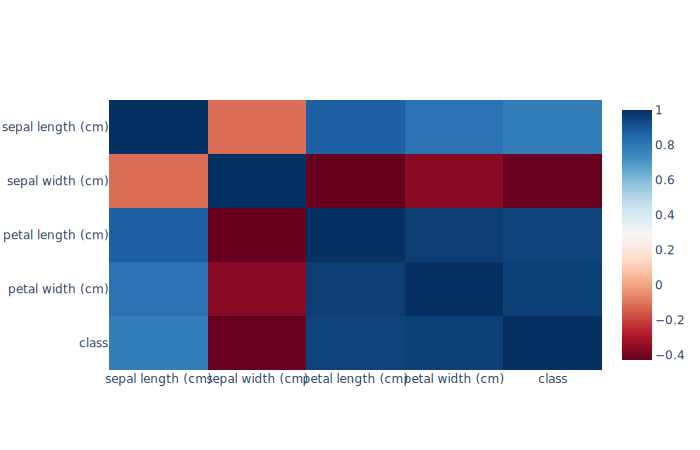

In [21]:
from sklearn.datasets import load_iris
import pandas as pd

# Load dataset
iris = load_iris()
X_sample = iris['data']
y_sample = np.reshape(iris['target'], (-1,1))
names = iris['target_names']
feat_names = np.append(iris['feature_names'], 'class')

# Plot correlation matrix
df = pd.DataFrame(np.append(X_sample,y_sample,1), columns=feat_names)
corr=df.corr()
fig5 = go.Figure(go.Heatmap(z=corr.values,x=corr.index.values, y=corr.columns.values, colorscale='RdBu'))
fig5.update_layout(yaxis_autorange='reversed')
fig5.show(renderer = 'svg')


A matriz de correlação mostra que não se pode ignorar nenhuma das *features* por haver alto grau de correlação entre elas. Apesar desta ter sido plotada antes de se forçar uma saída binária, devido ao baixo número de *features*, não se ignorou nenhuma delas para a implementação.

Assim como foi feito para o exercício anterior, utilizar-se-á a mesma função de custo e método de otimização por motivos já evidenciados.

O vetor de saída foi forçado a ter classes binárias, forçando todo valor $2$ se tornar $1$. Assim, a saída $0$ representa que a planta é da espécie setosa, enquanto uma saída $1$ indica que a planta não é dessa espécie.

Randomizou-se as amostras de treino e teste, garantindo a existência de $70\%$ de cada classe para treino e $30\%$ de cada classe para teste.

Após o treinamento da rede, calculou-se a acurácia e matrizes de confusão tanto para as amostras de treino quanto para testes:

Optimization terminated successfully.
         Current function value: 0.000064
         Iterations: 245
         Function evaluations: 431

Acuracia nas amostras de treino:  1.0
Acuracia nas amostras de teste:  1.0


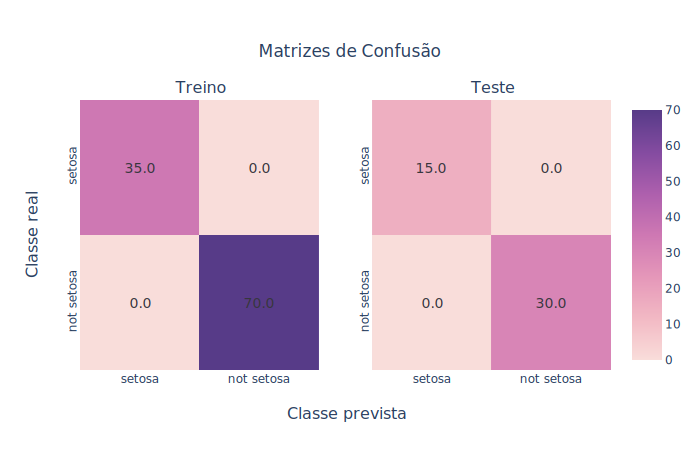

In [22]:
# Force second and third class to be the same
y_sample[y_sample==2] = 1

# Get random samples for training and test
N = len(y_sample)
N0 = len(y_sample[y_sample==0])
N1 = N-N0
rand_idx0 = np.arange(N0)
np.random.default_rng().shuffle(rand_idx0)
rand_idx1 = np.arange(N0, N)
np.random.default_rng().shuffle(rand_idx1)
N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
N_test0, N_test1 = N0-N_train0, N1-N_train1

X_train = X_sample[np.append(rand_idx0[0:N_train0], rand_idx1[0:N_train1]),:]
y_train = y_sample[np.append(rand_idx0[0:N_train0], rand_idx1[0:N_train1]),:]
X_test = X_sample[np.append(rand_idx0[N_train0::], rand_idx1[N_train1::]),:]
y_test = y_sample[np.append(rand_idx0[N_train0::], rand_idx1[N_train1::]),:]

# Randomly initialize weigth vector
L_in = np.shape(X_train)[1]
L_out = np.shape(y_train)[1]
epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
w = np.random.default_rng().uniform(-epsilon,epsilon,(L_in,L_out))

# Training and testing of neural network
w = np.reshape(fmin(cost_function, w, args=(X_sample, y_sample)), (-1,1))
y_hat_train = predict_label(activation_function(X_train @ w))
y_hat_test = predict_label(activation_function(X_test @ w))

# Compute accuracy and confusion matrix
ac_train = eval_accuracy(y_hat_train, y_train)
ac_test = eval_accuracy(y_hat_test, y_test)
print('\nAcuracia nas amostras de treino: ', float(ac_train))
print('Acuracia nas amostras de teste: ', float(ac_test))

cm_train = get_confusion_matrix(y_hat_train, y_train)
cm_test = get_confusion_matrix(y_hat_test, y_test)

fig6 = plot_confusion_matrix([cm_train, cm_test], ['setosa','not setosa'],'Matrizes de Confusão')
fig6.show(renderer = 'svg')


Obteve-se então excelentes acurácias tanto para o conjunto de treino quanto para o conjunto de testes, ambos iguais a $1.$ Também é possível notar que o algoritmo obeteve excelente *precision* e *recall*, o que indica uma boa aproximação.

Para se ter uma medida de acurácia mais confiável, pode-se iterar o algoritmo 100 vezes e calcular média e variância das acurácias obtidas. Também foi calculado o F-score de treinamento e teste, para se ter melhor avaliação do algoritmo. Isso foi feito da seguinte forma e o resultado é mostrado abaixo:

In [23]:
ac_train_list = []
ac_test_list = []
Fscore_train_list = []
Fscore_test_list = []

for i in range(100):
    rand_idx0 = np.arange(N0)
    np.random.default_rng().shuffle(rand_idx0)
    rand_idx1 = np.arange(N0, N)
    np.random.default_rng().shuffle(rand_idx1)
    N_train0, N_train1 = round(0.7*N0), round(0.7*N1)

    X_train = X_sample[np.append(rand_idx0[0 : N_train0], 
                       rand_idx1[0 : N_train1]), :]
    y_train = y_sample[np.append(rand_idx0[0:N_train0], 
                       rand_idx1[0 : N_train1]) , :]
    X_test = X_sample[np.append(rand_idx0[N_train0::], rand_idx1[N_train1::]),:]
    y_test = y_sample[np.append(rand_idx0[N_train0::], rand_idx1[N_train1::]),:]

    L_in = np.shape(X_train)[1]
    L_out = np.shape(y_train)[1]
    epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
    w = np.random.default_rng().uniform(-epsilon,epsilon,(L_in,L_out))

    w = np.reshape(fmin(cost_function, w, args=(X_sample, y_sample),
                   disp = 0), (-1,1))
    y_hat_train = predict_label(activation_function(X_train @ w))
    y_hat_test = predict_label(activation_function(X_test @ w))

    ac_train_list.append(eval_accuracy(y_hat_train, y_train).ravel())
    ac_test_list.append(eval_accuracy(y_hat_test, y_test).ravel())
    cm_train = get_confusion_matrix(y_hat_train, y_train)
    cm_test = get_confusion_matrix(y_hat_test, y_test)
    Fscore_test_list.append(2*cm_test[1,1]/(2*cm_test[1,1] + cm_test[0,1] 
                            + cm_test[1,0]))
    Fscore_train_list.append(2*cm_train[1,1]/(2*cm_train[1,1] + cm_train[0,1] 
                             + cm_train[1,0]))

mean_train = np.mean(ac_train_list)
mean_test = np.mean(ac_test_list)
var_train = np.var(ac_train_list)
var_test = np.var(ac_test_list)
print('Media das acuracias de treino: ', mean_train)
print('Media das acuracias de teste: ', mean_test)
print('Variancia das acuracias de treino: ', var_train)
print('Variancia das acuracias de teste: ', var_test)

Fscore_train_mean = np.mean(Fscore_train_list)
Fscore_test_mean = np.mean(Fscore_test_list)
Fscore_train_var = np.var(Fscore_train_list)
Fscore_test_var = np.var(Fscore_test_list)
print('\nMedia do Fscore de treino: ', Fscore_train_mean)
print('Media do Fscore de teste: ', Fscore_test_mean)
print('Variancia do Fscore de treino: ', Fscore_train_var)
print('Variancia do Fscore de teste: ', Fscore_test_var)

Media das acuracias de treino:  1.0
Media das acuracias de teste:  1.0
Variancia das acuracias de treino:  0.0
Variancia das acuracias de teste:  0.0

Media do Fscore de treino:  1.0
Media do Fscore de teste:  1.0
Variancia do Fscore de treino:  0.0
Variancia do Fscore de teste:  0.0



Vê-se que mesmo com $100$ iterações, o algoritmo obteve acurácia média de $1$ tanto para treino quanto para testes, com variância nula, o que indica que o algoritmo é ótimo. A média e variância do F-score também indicam a excelência do algoritmo.

# Base de maior dimensão - Breast Cancer

Uma vez que o número de *features* fornecidas pela base de dados é grande, 30, é interessante que se visualize a matriz de correlação entre as *features* e a classe de saída. Tomou-se então esse procedimento:

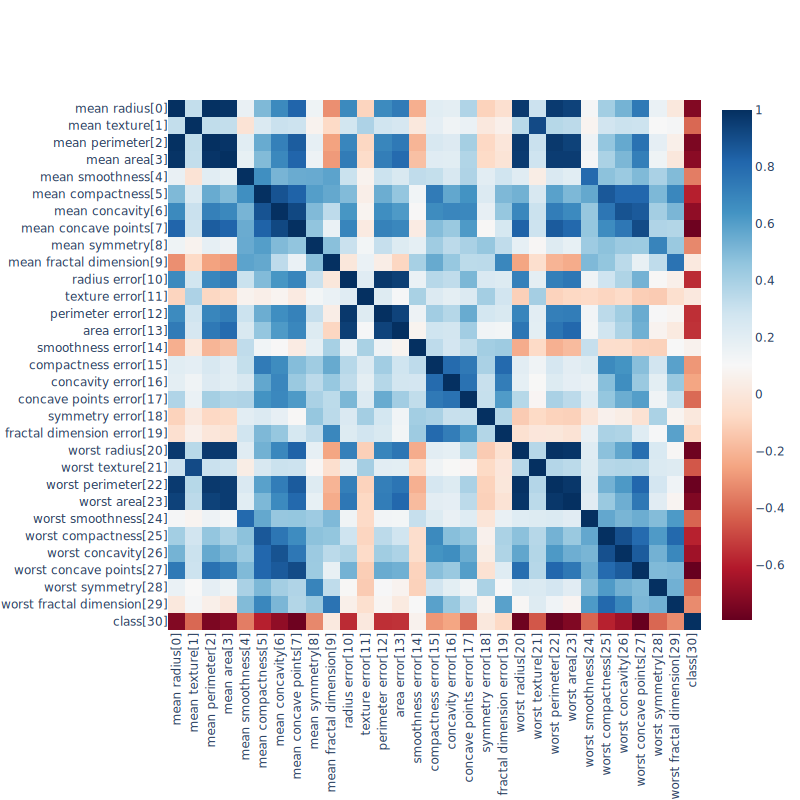

In [29]:
from sklearn.datasets import load_breast_cancer

# Load dataset
breast_cancer = load_breast_cancer()
X_samples = breast_cancer['data']
y_sample = np.reshape(breast_cancer['target'], (-1,1))
names = breast_cancer['target_names']
feat_names = np.append(breast_cancer['feature_names'], 'class')
feat_names = [name+'['+str(idx)+']' for idx, name in enumerate(feat_names)]

# Plot correlation matrix
df = pd.DataFrame(np.append(X_samples,y_sample,1), columns = feat_names)
corr = df.corr()
fig7 = go.Figure(go.Heatmap(z=corr.values,x=corr.index.values, y=corr.columns.values, colorscale='RdBu'))
fig7.update_layout(yaxis_autorange='reversed', width = 800, height =800, xaxis = dict(tickangle = -90))
fig7.show(renderer = 'svg', width = 800, height =800)



Avaliando-se a matriz de correlação, pôde-se perceber que as *features* com relação ao raio, perímetro e área são claramente dependetes, tendo valores praticamente idênticos de correlação com as demais. Sendo assim, optou-se por manter apenas as *features* de raio e desprezar todas com respeito a área e perímetro, ou seja, desprezou-se as *features* $2,3,12,13,22,23$. Ainda, pode-se notar que há *features* com correlação próxima a $0$ com a classe de saída, são essas $9,11,14,18,19$ que também podem ser desprezadas. Assim, ao todo, desprezou-se as *features* de número $2,3,9,11,12,13,14,18,19,22,23$.

Além de desprezar algumas *features*, fez-se uma normalização dos dados utilizando a relação $x_j'=\frac{x_j-\mu_j}{\sigma_j}$, onde $\mu_j$ é a média e $\sigma_j$ o desvio padrão da j-ésima *feature*.

Obteve-se então os índices do vetor de saída correspondente a cada classe, de forma a se obter, posteriormente, amostras aleatórias para treino e teste, sendo $70\%$, de cada classa, do vetor de saída fornecido alocado para treino e os demais $30\%$, de cada classe, alocados para teste.

Os pesos foram inicializados da mesma forma que anteriormente, assim como se manteve o algoritmo de minimização e função de custo.

A rede foi então treinada e foi calculada sua acurácia e matriz de confusão, mostradas após a implementação:


Acuracia nas amostras de treino:  0.9773869346733668
Acuracia nas amostras de teste:  0.9824561403508771


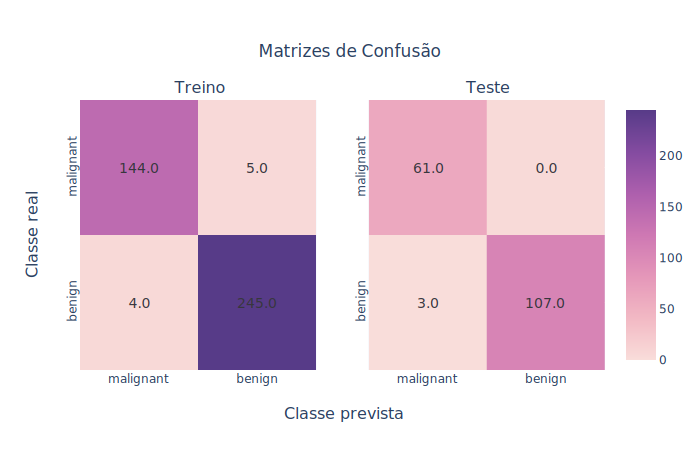

In [31]:
def normalize_features(X, mean, std):
    Xtemp = np.copy(X)
    Xtemp = Xtemp - mean
    Xtemp = Xtemp / std
    return Xtemp
    
def delete_features(X, feat_idx):
# Returns matrix X with features indexes in feat_idx ignored
    Xtemp = np.copy(X)
    Xtemp = np.delete(Xtemp, feat_idx,1)
    return Xtemp

N = np.shape(X_samples)[0]

# Normalize features
X_mean = np.mean(X_samples, axis = 0)
X_std = np.std(X_samples, axis = 0)
X_samplen = normalize_features(X_samples, X_mean, X_std)

# Remove useless features and append x0
ignored_idx = [2,3,9,11,12,13,14,18,19,22,23]
X_sample = delete_features(X_samplen, ignored_idx)
X_sample = np.append(np.ones((N,1)), X_sample, 1)

# Get indexes corresponding to each class
idx1 = [idx for idx, val in enumerate(y_sample.flatten()) if val==1]
idx0 = sorted(list(set(range(0,N)) - set(idx1)))
N0,N1 = len(idx0), len(idx1)
N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
# Randomize indexes
np.random.default_rng().shuffle(idx0)
np.random.default_rng().shuffle(idx1)

# Select samples for training and testing
X_train = X_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
X_test = X_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]
y_train = y_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
y_test = y_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]

# Randomly initialize weigth vector
L_in = np.shape(X_train)[1]
L_out = np.shape(y_train)[1]
epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
w = np.random.default_rng().uniform(-epsilon,epsilon,(L_in,L_out))

# Training and testing of neural network
w = np.reshape(fmin(cost_function, w, args=(X_sample, y_sample)), (-1,1))
y_hat_train = predict_label(activation_function(X_train @ w))
y_hat_test = predict_label(activation_function(X_test @ w))

# Compute accuracy and confusion matrix
ac_train = eval_accuracy(y_hat_train, y_train)
ac_test = eval_accuracy(y_hat_test, y_test)
print('\nAcuracia nas amostras de treino: ', float(ac_train))
print('Acuracia nas amostras de teste: ', float(ac_test))

cm_train = get_confusion_matrix(y_hat_train, y_train)
cm_test = get_confusion_matrix(y_hat_test, y_test)

fig8 = plot_confusion_matrix([cm_train, cm_test], names,'Matrizes de Confusão')
fig8.show(renderer = 'svg')


Percebe-se que mesmo desconsiderando as *features* citadas, o algoritmo teve excelente acurácia tanto para treino quanto para teste, além de bom *precision* e *recall*.

Novamente, para se ter melhor estimativa da acurácia, o algoritmo foi iterado $100$ vezes, de forma a se calcular sua média e variância. Também, estimou-se média e variância quanto ao F-score de treinamento e teste. A implementação e resultados são vistos a seguir:

In [32]:
ac_train_list = []
ac_test_list = []
Fscore_train_list = []
Fscore_test_list = []
for i in range(100):
    idx1 = [idx for idx, val in enumerate(y_sample.flatten()) if val==1]
    idx0 = sorted(list(set(range(0,N)) - set(idx1)))
    N0,N1 = len(idx0), len(idx1)
    N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
    np.random.default_rng().shuffle(idx0)
    np.random.default_rng().shuffle(idx1)

    X_train = X_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
    X_test = X_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]
    y_train = y_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
    y_test = y_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]

    L_in = np.shape(X_train)[1]
    L_out = np.shape(y_train)[1]
    epsilon = np.sqrt(6)/np.sqrt(L_in+L_out)
    w = np.random.default_rng().uniform(-epsilon,epsilon,(L_in,L_out))

    w = np.reshape(fmin(cost_function, w, args=(X_sample, y_sample), 
                   disp=0), (-1,1))
    y_hat_train = predict_label(activation_function(X_train @ w))
    y_hat_test = predict_label(activation_function(X_test @ w))

    ac_train_list.append(eval_accuracy(y_hat_train, y_train).ravel())
    ac_test_list.append(eval_accuracy(y_hat_test, y_test))
    cm_train = get_confusion_matrix(y_hat_train, y_train)
    cm_test = get_confusion_matrix(y_hat_test, y_test)
    Fscore_test_list.append(2*cm_test[1,1]/(2*cm_test[1,1] + cm_test[0,1] 
                            + cm_test[1,0]))
    Fscore_train_list.append(2*cm_train[1,1]/(2*cm_train[1,1] + cm_train[0,1] 
                             + cm_train[1,0]))

mean_train = np.mean(ac_train_list)
mean_test = np.mean(ac_test_list)
var_train = np.var(ac_train_list)
var_test = np.var(ac_test_list)
print('Media das acuracias de treino: ', mean_train)
print('Media das acuracias de teste: ', mean_test)
print('Variancia das acuracias de treino: ', var_train)
print('Variancia das acuracias de teste: ', var_test)

Fscore_train_mean = np.mean(Fscore_train_list)
Fscore_test_mean = np.mean(Fscore_test_list)
Fscore_train_var = np.var(Fscore_train_list)
Fscore_test_var = np.var(Fscore_test_list)
print('\nMedia do Fscore de treino: ', Fscore_train_mean)
print('Media do Fscore de teste: ', Fscore_test_mean)
print('Variancia do Fscore de treino: ', Fscore_train_var)
print('Variancia do Fscore de teste: ', Fscore_test_var)

Media das acuracias de treino:  0.9785175879396985
Media das acuracias de teste:  0.9791812865497076
Variancia das acuracias de treino:  4.5753263806469576e-05
Variancia das acuracias de teste:  0.00011922984850039341

Media do Fscore de treino:  0.9829691476513922
Media do Fscore de teste:  0.9834373238873565
Variancia do Fscore de treino:  2.8298988860635936e-05
Variancia do Fscore de teste:  7.523068459366886e-05


Com o resultado de $100$ iterações, pode-se perceber que a acurácia do algoritmo foi excelente tanto para treino quanto para testes, sendo de $98\%$ aproximadamente, apresentando variância baixa, o que é indicativo de um bom algoritmo. A média e variância do F-score de treino e teste também indicam a qualidade da rede neural treinada.